# Objective: Forecasting Locality and Property Price

## Import Libraries 

In [42]:
import pandas as pd 
import numpy as np 

import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns 

import pickle
import json

from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm 
from statsmodels.tsa.arima.model import ARIMA


import warnings 
warnings.filterwarnings('ignore')

## Exploratory data analysis in a function 

In [2]:
raw_data = pd.read_csv('Forecast_property.csv')
def getData(label='locality',name='Dombivli East',method='nearest'):
    hold_data = raw_data[(raw_data.label == label.upper()) & (raw_data.name == name)].copy(deep=True)
    hold_data.date = pd.to_datetime(hold_data.date)
    hold_data.dropna(inplace=True)
    hold_data = hold_data.drop(columns=['budgetRange','name','label','quarter'])
    hold_data.rename(columns={'price(per.sqft)':'price'},inplace=True)
    hold_data['Quarter'] = hold_data.date.dt.to_period('Q')
    hold_data.drop(columns=['date'],axis=1,inplace=True)
    hold_data.drop_duplicates(inplace=True)
    hold_data = hold_data.groupby(by='Quarter').mean()
    hold_data = hold_data.sort_index()
    hold_data = hold_data.resample('Q').interpolate(method)
    do_forecast = bool(sum([(i.year in [2022,2023])  for i in hold_data.index[-4:]]))
    return {'data':hold_data,
            'do_forecast':do_forecast}
pivot = pd.pivot_table(raw_data[['label','name']],index=['label','name']).copy(deep=True)
perm_com = {'LOCALITY':list(pivot.index.get_level_values(1)[pivot.index.get_level_values(0)=='locality'.upper()]),
            'PROJECT':list(pivot.index.get_level_values(1)[pivot.index.get_level_values(0)=='project'.upper()])}

# Model Buidling
- Adfuller Test
- ACF & PACF plots
- ARMA model

## 1] Locality- Balaji Nagar

In [3]:
data = getData(name='Balaji Nagar',label='locality')['data']

In [4]:
adfuller(data.values.ravel())

(2.0791584504634386,
 0.9987673820449665,
 5,
 9,
 {'1%': -4.473135048010974,
  '5%': -3.28988060356653,
  '10%': -2.7723823456790124},
 104.9189129054855)

In [5]:
val = data.values.ravel()
first_diff = val[1:]-val[:-1]

In [6]:
adfuller(first_diff)

(-5.65432852081489,
 9.69867847684715e-07,
 5,
 8,
 {'1%': -4.6651863281249994, '5%': -3.3671868750000002, '10%': -2.802960625},
 73.35273297298043)

In [7]:
i = 1

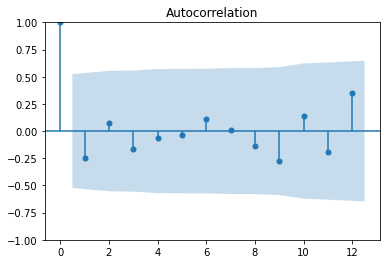

In [8]:
# MA model
plot_acf(first_diff)
plt.show()
p = 0

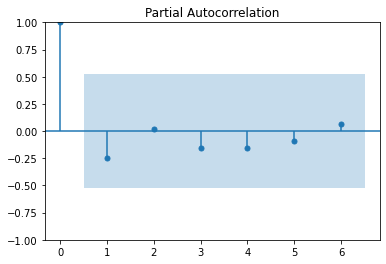

In [9]:
# AR model
plot_pacf(first_diff,lags=6,method='ywm')
plt.show()
q = 0

In [10]:
order = (p,i,q)
order 

(0, 1, 0)

In [11]:
model = ARIMA(val,order=(0,1,0)).fit()

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   15
Model:                 ARIMA(0, 1, 0)   Log Likelihood                 -91.598
Date:                Wed, 15 Feb 2023   AIC                            185.196
Time:                        13:27:46   BIC                            185.836
Sample:                             0   HQIC                           185.137
                                 - 15                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      2.821e+04   7357.399      3.834      0.000    1.38e+04    4.26e+04
===================================================================================
Ljung-Box (L1) (Q):                   1.02   Jarque-Bera (JB):                 4.87
Prob(Q):                              0.31   Prob(JB):                         0.09
Heteroskedasticity (H):               0.85   Skew:                             1.39
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## 2] Project -Runwal My City

In [13]:
runwal = getData(label='project',name='Runwal My City')['data']

In [14]:
adfuller(runwal)

(-1.9758931837311033,
 0.297242083948243,
 10,
 23,
 {'1%': -3.7529275211638033,
  '5%': -2.998499866852963,
  '10%': -2.6389669754253307},
 341.3114617869243)

In [15]:
runwal.head()

,price
Quarter,
2014Q3,4450.0
2014Q4,4600.0
2015Q1,4600.0
2015Q2,5150.0
2015Q3,5400.0


In [16]:
runwal['first_diff'] = runwal.price - runwal.price.shift(1)

In [17]:
runwal.dropna(inplace=True)

In [18]:
runwal.head()

,price,first_diff
Quarter,,
2014Q4,4600.0,150.0
2015Q1,4600.0,0.0
2015Q2,5150.0,550.0
2015Q3,5400.0,250.0
2015Q4,5300.0,-100.0


In [19]:
adfuller(runwal.first_diff)
i = 1

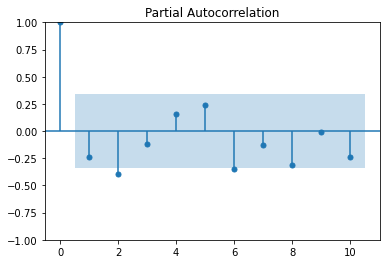

In [20]:
# AR models
plot_pacf(runwal.first_diff,lags=10,method='ywm')
plt.show()
p = 2

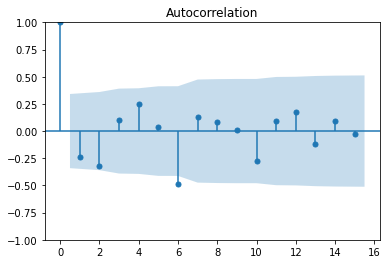

In [21]:
# MA model
plot_acf(runwal.first_diff,lags=15)
plt.show()
q = 6

In [22]:
order = (p,i,q)
order

(2, 1, 6)

In [23]:
model = ARIMA(runwal.price,order=(2,1,6)).fit()

## 3] Project- Regency Anantam

In [24]:
regency = getData(label='project',name='Regency Anantam')['data']

In [25]:
# no diff
raw = regency.price.values.ravel()
adfuller(raw)

(-0.2997973376164609,
 0.925533030365009,
 6,
 10,
 {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487},
 149.58073891425738)

In [26]:
# first diff
raw = raw[1:]-raw[:-1]
adfuller(raw)

(-2.364335742959198,
 0.1520563613853969,
 5,
 10,
 {'1%': -4.331573, '5%': -3.23295, '10%': -2.7487},
 130.57402756132313)

In [27]:
# second diff
raw = raw[1:]-raw[:-1]
adfuller(raw)

(-4.835480668829896,
 4.649434579992521e-05,
 3,
 11,
 {'1%': -4.223238279489106,
  '5%': -3.189368925619835,
  '10%': -2.729839421487603},
 141.60072761370608)

In [28]:
i = 2

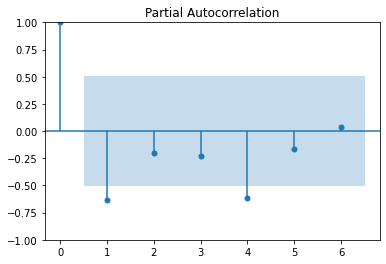

In [29]:
# AR model
plot_pacf(raw,lags=6,method='ywm')
plt.show()
p = 1  # 1,4

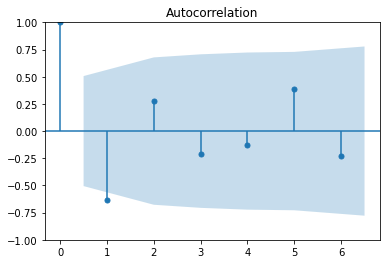

In [30]:
# MA model
plot_acf(raw,lags=6)
plt.show()
q = 1

In [31]:
order = (p,i,q)
order

(1, 2, 1)

In [32]:
model = ARIMA(regency.price, order=(1,2,1)).fit()

In [33]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  price   No. Observations:                   17
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -117.042
Date:                Wed, 15 Feb 2023   AIC                            240.084
Time:                        13:27:51   BIC                            242.208
Sample:                    12-31-2018   HQIC                           240.061
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0947      0.216      0.437      0.662      -0.330       0.519
ma.L1         -0.9987      0.425     -2.347      0.019      -1.833      -0.165
sigma2      2.176e+05   1.98e-06    1.1e+11      0.000    2.18e+05    2.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.48   Jarque-Bera (JB):                 0.72
Prob(Q):                              0.49   Prob(JB):                         0.70
Heteroskedasticity (H):               0.13   Skew:                            -0.46
Prob(H) (two-sided):                  0.04   Kurtosis:                         2.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.24e+26. Standard errors may be unstable.
"""

<AxesSubplot:>

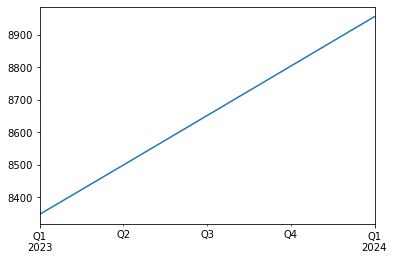

In [34]:
model.forecast(5).plot()

In [35]:
name = ['PROJECT Lodha Palava City',
'PROJECT Lodha Lakeshore Greens',
'PROJECT Lodha Casario',
'PROJECT Lodha Casa Rio Gold',
'PROJECT Lodha Casa Bella Gold',
'PROJECT Happy Sarvodaya Trilok',
'LOCALITY Sagarli',
'LOCALITY Sagaon',
'LOCALITY Nilje Gaon',
'LOCALITY Dawadi Gaon',
'LOCALITY Balaji Nagar',
'PROJECT Shree Chamunda Garden',
'PROJECT Runwal My City',
'PROJECT Neelsidhi Balaji Garden',
'PROJECT Lodha Regency',
'PROJECT Lodha Palava Downtown',
'PROJECT Lodha Golflinks',
'PROJECT Lodha Exotica',
'PROJECT Lodha Casa Bella',
'LOCALITY thakurli',
'LOCALITY Sunil Nagar',
'LOCALITY Pendse Nagar',
'LOCALITY Nandivali Panchanand',
'LOCALITY Dombivli East',
'PROJECT Regency Anantam',
'LOCALITY P and T Colony',
'LOCALITY Nandivali Gaon',
'PROJECT Anantnath And Forever City',
'LOCALITY Nandivli',
'LOCALITY Gograswadi',
'PROJECT Siddharth Riverwood Park']

In [36]:
ls = [[i.split(' ')[0],' '.join(i.split(' ')[1:])] for i in name]

In [37]:
order= [(1,0,2),(1,0,2),(1,0,1),(1,0,1),(1,0,1),(1,0,1),(1,0,0),(2,0,2),(1,0,1),(1,0,1),
(0,1,0),(0,1,0),(2,1,6),(0,1,0),(0,1,0),(2,1,2),(0,1,0),(4,1,4),(0,1,0),
(0,1,0),(0,1,0),(0,1,0),(0,1,0),(0,1,0),(1,2,1),(1,2,1),(1,2,1),(1,3,1),(1,3,1),
(1,2,1),(1,5,1)]

In [38]:
num = 0
info = list(zip(ls,order))[num]
data = getData(label=info[0][0],name=info[0][1])['data']
model = ARIMA(data,order=info[-1]).fit()

In [39]:
for i in list(zip(ls,order)):
    data = getData(label=i[0][0],name=i[0][1])['data']
    model = ARIMA(data,order=i[-1]).fit()
    data.tail(5)
    model.forecast(5)

In [40]:
info = list(zip(ls,order))
info

[(['PROJECT', 'Lodha Palava City'], (1, 0, 2)),
 (['PROJECT', 'Lodha Lakeshore Greens'], (1, 0, 2)),
 (['PROJECT', 'Lodha Casario'], (1, 0, 1)),
 (['PROJECT', 'Lodha Casa Rio Gold'], (1, 0, 1)),
 (['PROJECT', 'Lodha Casa Bella Gold'], (1, 0, 1)),
 (['PROJECT', 'Happy Sarvodaya Trilok'], (1, 0, 1)),
 (['LOCALITY', 'Sagarli'], (1, 0, 0)),
 (['LOCALITY', 'Sagaon'], (2, 0, 2)),
 (['LOCALITY', 'Nilje Gaon'], (1, 0, 1)),
 (['LOCALITY', 'Dawadi Gaon'], (1, 0, 1)),
 (['LOCALITY', 'Balaji Nagar'], (0, 1, 0)),
 (['PROJECT', 'Shree Chamunda Garden'], (0, 1, 0)),
 (['PROJECT', 'Runwal My City'], (2, 1, 6)),
 (['PROJECT', 'Neelsidhi Balaji Garden'], (0, 1, 0)),
 (['PROJECT', 'Lodha Regency'], (0, 1, 0)),
 (['PROJECT', 'Lodha Palava Downtown'], (2, 1, 2)),
 (['PROJECT', 'Lodha Golflinks'], (0, 1, 0)),
 (['PROJECT', 'Lodha Exotica'], (4, 1, 4)),
 (['PROJECT', 'Lodha Casa Bella'], (0, 1, 0)),
 (['LOCALITY', 'thakurli'], (0, 1, 0)),
 (['LOCALITY', 'Sunil Nagar'], (0, 1, 0)),
 (['LOCALITY', 'Pendse Naga

In [41]:
fileMap = {}
count = 0
for point in info:
    label, name , order = point[0][0] ,point[0][-1], point[-1]
    data = getData(label=label,name=name)['data']
    model = ARIMA(data,order=order).fit()
    # save model 
    path = 'forecast models\\'+label+'_'+name+'.pkl'
    pickle.dump(model,open(path,'wb'))
    # add that file name to fileMap
    fileMap[name] = path
    count += 1
with open('forecast models\\'+'fileMap.json','w') as file:
    json.dump(fileMap,file,indent=4)

In [43]:
filemap = json.load(open(r'forecast models\fileMap.json','rb'))
forecast = {}
for name in filemap.keys():
    forecast[name] = pickle.load(open(filemap[name],'rb'))

In [44]:
model = forecast['thakurli']

In [45]:
model.forecast(4)

2023Q1    7600.0
2023Q2    7600.0
2023Q3    7600.0
2023Q4    7600.0
Freq: Q-DEC, Name: predicted_mean, dtype: float64

In [46]:
# if quarter == 3 then forecast number -> 5
# else 4
getData(name=name,label=label)['data'].index[-1].quarter 

4

In [48]:
x = [1,2,3]
x

[1, 2, 3]

## Added the above data in 'app.py'  file 
- Further script written in app.py file for streamlit deployment